In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
import datetime as dt
from datetime import datetime
import bz2
import pickle
import _pickle as cPickle
import timeit
from __main__ import download_tickers, tickers

%matplotlib inline

In [159]:
tickers = pd.read_csv('danish_first_north.csv', header=None)

In [160]:
tickers = tickers[0].to_list()

In [228]:
tickers = ['SPY', 'EZA', 'ASTGRPJ.CO']
#timeit.timeit("stocks = download_tickers(tickers)", "from __main__ import download_tickers, tickers", number=1)
stocks = download_tickers(tickers)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ASTGRPJ.CO: No data found, symbol may be delisted
['MYI.L', 'UC84.L', 'PRIP.L', 'NVEC', 'GBX', 'RS2U.L', 'UNH', 'CREO.L', 'ORRF', 'IEMD.L', 'AIGC.L', 'MJCO', 'LEUR.L', 'REAL', 'EGDM.L', 'GJGB.L', 'PMT', 'GSPX.L', 'JOG.L', 'GLW', '78GL.L', 'HINT.L', 'TREX', 'RYI', 'MRC', 'ACM', 'FBH.L', 'CLCT', 'XPS.L', 'AQSG.L', 'GPI', 'OXY', 'G4S.CO', 'NATH', 'MNTN.L', 'ARAY', 'WHD', 'EMLC.L', 'FXZ', 'AAT', 'TGNA', 'SECI.ST', 'NUC.L', 'DIST.ST', 'OMER', 'AMYT.L', 'ALLO', 'HCM.L', 'FIVN', 'AJA-B.ST', 'TRUP', 'IOVA', 'MMK.L', 'XPAL.L', 'LGB3.L', 'AEJL.L', 'HLCL.L', 'KALA', 'WDR', 'ABB.ST', 'HRUD.L', 'LTRPA', 'SUKC.L', 'GLEN.L', 'SYS.L', 'SAVOS-TO6.ST', 'ARE.L', 'IAUP.L', 'CRWN.L', 'QRT.L', 'GEF', 'AVB', 'AVV.L', 'FRXD.L', 'PVG.L', 'XLU', 'NEE', 'CCSL.L', 'J', 'PAPI.ST', 'CRDA.L', 'JNJ', 'CBAY', 'ENET.L', 'VIS2.L', 'RNO.L', 'CLXT', 'ASPS', 'BDC', 'HUDYA.ST', 'KFY', 'IRR.L', 'THFF', 'JPM', 'ADS', 'IHDG', 'CEUS.L', '

In [229]:
stocks

Stock ticker         SPY                                                  \
Data type           Open        High         Low       Close   Adj Close   
Date                                                                       
1993-01-29     43.968750   43.968750   43.750000   43.937500   26.184059   
1993-02-01     43.968750   44.250000   43.968750   44.250000   26.370279   
1993-02-02     44.218750   44.375000   44.125000   44.343750   26.426161   
1993-02-03     44.406250   44.843750   44.375000   44.812500   26.705482   
1993-02-04     44.968750   45.093750   44.468750   45.000000   26.817228   
...                  ...         ...         ...         ...         ...   
2020-08-31    350.350006  351.299988  349.059998  349.309998  349.309998   
2020-09-01    350.209991  352.709991  349.239990  352.600006  352.600006   
2020-09-02    354.670013  358.750000  353.429993  357.700012  357.700012   
2020-09-03    355.869995  356.380005  342.589996  345.390015  345.390015   
2020-09-04    346.130005  347.829987  334.880005  342.570007  342.570007   

Stock ticker                   EZA                                   \
Data type        Volume       Open       High        Low      Close   
Date                                                                  
1993-01-29      1003200        NaN        NaN        NaN        NaN   
1993-02-01       480500        NaN        NaN        NaN        NaN   
1993-02-02       201300        NaN        NaN        NaN        NaN   
1993-02-03       529400        NaN        NaN        NaN        NaN   
1993-02-04       531500        NaN        NaN        NaN        NaN   
...                 ...        ...        ...        ...        ...   
2020-08-31     66099200  37.759998  37.759998  36.930000  37.169998   
2020-09-01     54999300  38.430000  38.470001  38.049999  38.360001   
2020-09-02     69540000  37.619999  37.660000  37.110001  37.580002   
2020-09-03    147485600  37.070000  37.200001  36.259998  36.650002   
2020-09-04    139156281  37.139999  37.457298  36.520000  37.189999   

Stock ticker                       
Data type     Adj Close    Volume  
Date                               
1993-01-29          NaN       NaN  
1993-02-01          NaN       NaN  
1993-02-02          NaN       NaN  
1993-02-03          NaN       NaN  
1993-02-04          NaN       NaN  
...                 ...       ...  
2020-08-31    37.169998  753200.0  
2020-09-01    38.360001  340800.0  
2020-09-02    37.580002  538200.0  
2020-09-03    36.650002  509800.0  
2020-09-04    37.189999  582333.0  

[6952 rows x 12 columns]

In [168]:
sns.lineplot(data=stocks.loc[:, stocks.columns.get_level_values(1).isin(['Volume'])])

ValueError: These `style` levels are missing dashes: {'MDUNDO.CO', 'NPINV.CO', 'ODICO.CO', 'GREENM.CO', 'HYPE.CO', 'STENO.CO', 'WATURU.CO', 'MONSO.CO', 'SHAPE.CO', 'LEDIBOND.CO', 'KONSOL.CO', 'HAPPY.CO', 'ERRIA.CO', 'FASTPC.CO', 'WIRTEK.CO', 'ENALYZ.CO', 'PENNEO.CO', 'SLXIT.CO', 'JOBNDX.CO', 'FOM.CO', 'VIRO.CO', 'HRC.CO', 'SCAPE.CO', 'ESOFT.CO'}

In [230]:
def download_tickers(tickers):
    # Fetch downloaded ticker from raw_data
    downloaded_tickers = [x[0:-5] if '.pbz2' in x else '' for x in os.listdir('raw_data/')]
    downloaded_tickers.remove('')
    # Check if tickers already are downloaded
    tickers_to_download = []
    for ticker in tickers:
        if ticker in downloaded_tickers:
            # If already downloaded, check if they need updates
            if update_ticker(ticker):
                tickers_to_download.append(ticker)
        else:
            tickers_to_download.append(ticker)

    not_downloaded = download_dump(tickers_to_download)
    tickers_to_load = [x for x in tickers if x not in not_downloaded]
    # Read tickers from json and return
    return load_stocks(tickers_to_load)

In [219]:
def load_stocks(tickers):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    index = pd.MultiIndex.from_product([tickers, cols], names=['Stock ticker', 'Data type'])
    if len(tickers) > 1:
        data = pd.concat([decompress_pickle('raw_data/' + x + '.pbz2') for x in tickers], axis=1, sort=True)
    else:
        data = decompress_pickle('raw_data/' + tickers[0] + '.pbz2')
    
    data.columns = index
    try:
        data.index = pd.to_datetime(data.index, unit='ms')
    except ValueError:
        data.index = pd.to_datetime(data.index)
    return data

In [220]:
def update_ticker(ticker):
    last_bday = last_weekday()
    newest_date = decompress_pickle('raw_data/' + ticker + '.pbz2').index[-1]
    if newest_date == float:
        newest_date = dt.datetime.fromtimestamp(newest_date/1000).date()
    if newest_date != last_bday:
        return True 
    else:
        return False

In [223]:
def download_dump(tickers):
    not_downloaded = []
    if tickers != []:
        data = yf.download(tickers, period='100y', group_by='tickers')
        if len(tickers) > 1:
            for ticker in tickers:
                    clean_data = clean_df(data[ticker])
                    if len(clean_data) > 1:
                        compressed_pickle(ticker, clean_data)
                    else:
                        not_downloaded.append(tickers)
        else:
            clean_data = clean_df(data)
            if len(clean_data) > 1:
                compressed_pickle(tickers[0], clean_data)
            else:
                not_downloaded.append(tickers[0])
                
    return not_downloaded 

In [224]:
def last_weekday():
    todays_day = dt.date.today().day
    if todays_day in [5, 6]:
        return dt.date.today() - dt.timedelta(days=todays_day-4)
    else:
        return dt.date.today()


In [225]:
def clean_df(df):
    df = df.dropna(axis = 0, how='all')
    return df

In [226]:
def compressed_pickle(ticker, data):
    with bz2.BZ2File('raw_data/' + ticker + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [227]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [204]:
test = decompress_pickle('raw_data/EZA.pbz2')

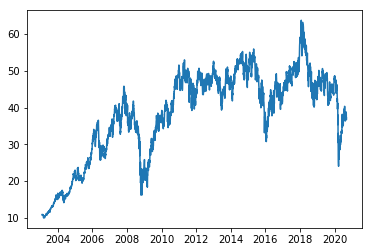

In [180]:
sns.lineplot(data=test['Adj Close'])

In [ ]:
import os

def clean_raw_files():
    for filename in os.listdir('raw_data'):
        if filename.endswith(".pbz2"): 
            df = pd.DataFrame(decompress_pickle('raw_data/' + filename))
            non_zeroes = len(df) - df.iloc[:, 4].isna().sum()
            if non_zeroes < 2:
                os.remove('raw_data/' + filename)
            else:
                df = df.dropna(how='all', axis=0)
                ticker = filename.replace('.pbz2', '')
                compressed_pickle(ticker, df)
                  
remove_empties()